## Customized QCA Optimizer

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import quad
from scipy.stats import zscore
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from sklearn.preprocessing import StandardScaler, MinMaxScaler, KernelCenterer
from sklearn import preprocessing
from functools import partial

import random

In [13]:
q_data_ = [np.loadtxt(f'q{i}_t1vsfreq.txt', delimiter=',') for i in range(1, 14)]
q_data = q_data_.copy()
g = [(1,2), 
    (1,13),
    (2,3),
    (2,5),
    (2,4),
    (4,7),
    (4,9),
    (4,13),
    (5,7),
    (6,7),
    (7,8),
    (8,9),
    (9,10),
    (9,11),
    (11,13),
    (12,13)]

D = 0.5
alpha = 0.02
delta_x = 0.005

In [14]:
def filtered_freq_and_time(one_qubit_data):
    freq, time = one_qubit_data[:,0], one_qubit_data[:,1]
    z_scores = zscore(freq)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)  # Keeping data points with Z-score less than 3
    filtered_freq = freq[filtered_entries]
    filtered_time = time[filtered_entries]
    return filtered_freq, filtered_time


def cardinality(g, node):
    count = 0
    for edge in g:
        if node in edge:
            count += 1
    return count


def most_neighbors_node(g, U):
    max_neighbors = 0
    for node in U:
        num_neighbors = cardinality(g, node)
        if num_neighbors >= max_neighbors:
            max_neighbors = num_neighbors
            idx = node
    return idx

def determined_neighbors(g, node, assigned_freqs):
    neighbors = []
    for a, b in g:
        if a == node:
            neighbors.append(b)
        elif b == node:
            neighbors.append(a)    
    neighbors = [n for n in neighbors if n in assigned_freqs.keys()]
    return neighbors

def legal_gradient(assigned_freq, one_q, gradient_threshold=0.2, distance=0.025):
    freqs, t1s = one_q
    neighbor_idx = np.where(np.abs(freqs - assigned_freq) <= distance)[0]
    if len(neighbor_idx) == 0:
        return True
    for idx in neighbor_idx:
        if idx == 0 or idx == len(freqs) - 1:
            continue
        if abs(t1s[idx+1] - t1s[idx-1]) / t1s[idx] > gradient_threshold:
            return False
    return True
    

# Neighboring constraint
def legal_neighbor(neighbors, assigned_freqs, freq):
    if neighbors == []:
        return True
    for node in neighbors:
        diff = abs(assigned_freqs[node] - freq)
        if diff > D or diff < alpha:
            return False
    return True

In [15]:
qdata = {}
for i, one_q in enumerate(q_data.copy()):
    qdata[i+1] = filtered_freq_and_time(one_q)


In [16]:
def freq_placer(g, qdata, order = None, params = (alpha, D)): # index starts at 1
    U = [i for i in qdata.keys()] # nodes to be assigned
    assigned_freq = {}
    assigned_t1 = {}
    exe_order = []

    while U != []:
        if order != None:
            t = order.pop(0)
        else:
            t = most_neighbors_node(g, U)
        exe_order.append(t)
        t_freq_data, t_t1_data = qdata[t]
        if assigned_freq == {}:
            max_t1 = max(t_t1_data) # can consider multiple solutions
            idx = list(t_t1_data).index(max_t1)
            assigned_freq[t] = t_freq_data[idx]
            assigned_t1[t] = max_t1
        else:
            neighbors = determined_neighbors(g, t, assigned_freq)

            candidate = [] # narrow down candidates
            for freq, t1 in zip(t_freq_data, t_t1_data):
                if legal_neighbor(neighbors, assigned_freq, freq):
                    candidate.append((freq, t1))
            if candidate == []:
                print("No candidate")
                return None, None
            
            max_t1 = max([t1 for _, t1 in candidate])
            idx = list(t_t1_data).index(max_t1)
            assigned_freq[t] = t_freq_data[idx]
            assigned_t1[t] = max_t1
        
        U.remove(t)
    print("execute order", exe_order)
    return assigned_freq, assigned_t1

## 数据平滑

In [17]:
def smooth_dataset(x_vals, y_vals, delta=0.01):
    """
    Smooths the y values by averaging over neighboring points within delta distance in x values.
    
    Returns:
    np.array: Smoothed y values.
    """
    smoothed_y = np.zeros_like(y_vals)

    for i, x in enumerate(x_vals):
        # Find all x values within delta distance of the current x point
        neighbors_idx = np.where(np.abs(x_vals - x) <= delta)[0]
        # Average the corresponding y values
        smoothed_y[i] = np.mean([y_vals[j] for j in neighbors_idx])

    return smoothed_y

In [18]:
qdata_smoothed = qdata.copy()
for i, (freq, t1) in qdata.items():
    qdata_smoothed[i] = (freq, smooth_dataset(freq, t1))


legal_freq_dots = {}
for i, one_q in qdata_smoothed.items():
    temp = []
    freqs, t1s = one_q
    for freq in freqs:
        if legal_gradient(freq, one_q):
            idx = list(freqs).index(freq)
            temp.append((freq, t1s[idx]))
    legal_freq_dots[i] = temp

# stable data points
qdata_stable = {}
for i in legal_freq_dots.keys():
    freqs, t1s = zip(*legal_freq_dots[i])
    qdata_stable[i] = (np.array(freqs), np.array(t1s))

In [19]:
# constrain: distance to a deep gradient
# distance: +/- 0.025
# gradient_threshold: y'/y <= 0.2

def run_n_visualize(qdata, labels, order_list, g=g, params=(alpha, D)):
    results = []
    for opt_order in order_list:
        if opt_order == None:
            opt_order = [i+1 for i in range(len(qdata))]
            random.shuffle(opt_order)
        freqs, t1s = freq_placer(g, qdata, opt_order, params=params)
        results.append((freqs, t1s))
        if freqs == None:
            print("No solution found")
            return
    
    for i, (assigned_freq, assigned_t1) in enumerate(results):
        x_list = [i+1 for i in range(len(assigned_t1))]
        mean_T1s = {i: np.mean(qdata[i][1]) for i, _ in qdata.items()}

        y_list = [assigned_t1[i+1] - mean_T1s[i+1] for i in range(len(qdata))]
        zero_line = [0 for _ in range(len(qdata))]

        plt.plot(x_list, y_list, label=labels[i])
        print()
        print(labels[i])
        print("sum of t1: ", np.round(sum(assigned_t1.values()), 3))
        print("sum of t1 * delta x:", np.round(sum(assigned_t1.values()) * delta_x, 3), "\n")
    
    plt.plot(x_list, zero_line, label="Zero line")
    plt.title("Difference between assigned T1 and mean T1")
    plt.xlabel("Qubit index")
    plt.ylabel("Solved t1 - Mean t1")
    plt.legend()
    plt.show()

    x_labels = [f"({edge[0]}, {edge[1]})" for edge in g]
    alpha_line = [alpha for _ in range(len(g))]

    D_line = [D for _ in range(len(g))]
    for k, (assigned_freq, assigned_t1) in enumerate(results):
        freq = {i: assigned_freq[i] for i in assigned_freq.keys()}

        freq_diff = [abs(freq[j] - freq[i]) for i, j in g]
        plt.plot(x_labels, freq_diff, label = labels[k])

    plt.plot(x_labels, alpha_line, label='alpha', color='purple')
    plt.plot(x_labels, D_line, label='D', color='brown')

    # Adding labels and title
    plt.xlabel('Edges')
    plt.ylabel('Absolute Frequency Difference')
    plt.title('Adjacent Nodes vs Frequency Difference')

    plt.legend()
    plt.xticks(rotation=45, ha='right')

    pts = []
    for i in range(1, 14):
        temp = []
        for freq, t1 in results:
            temp.append([(freq[i], t1[i])])
        pts.append(temp)
    print("point", pts)
    return pts


def visualize_results(qdata, pts, labels):
    if pts == None:
        return
    for i, (freq, t1) in qdata.items():
        plt.scatter(freq, t1, color='yellow', label='Data points')
        plt.title(f'Qubit {i} T1 vs Frequency')

        for j, dots in enumerate(pts[i-1]):
            plt.scatter(dots[0][0], dots[0][1], label=labels[j])
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('T1 (ms)')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

execute order [6, 7, 9, 5, 3, 2, 4, 12, 13, 11, 1, 10, 8]
execute order [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12]
execute order [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]

random
sum of t1:  1875.845
sum of t1 * delta x: 9.379 


center first
sum of t1:  1875.845
sum of t1 * delta x: 9.379 


edge first
sum of t1:  1875.845
sum of t1 * delta x: 9.379 



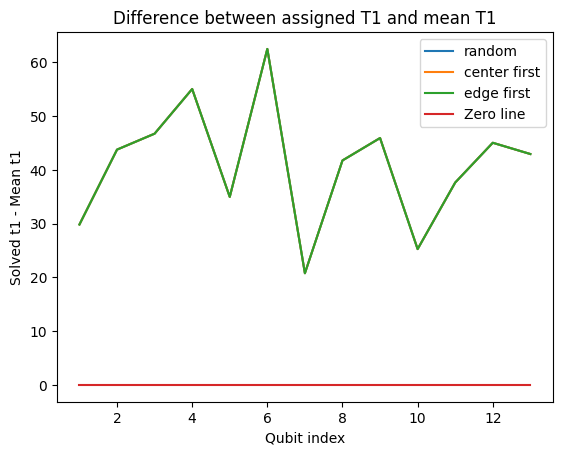

point [[[(np.float64(4.52), np.float64(144.24765999999997))], [(np.float64(4.52), np.float64(144.24765999999997))], [(np.float64(4.52), np.float64(144.24765999999997))]], [[(np.float64(4.4365), np.float64(150.92449000000002))], [(np.float64(4.4365), np.float64(150.92449000000002))], [(np.float64(4.4365), np.float64(150.92449000000002))]], [[(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))]], [[(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))]], [[(np.float64(4.2173), np.float64(135.99491666666665))], [(np.float64(4.2173), np.float64(135.99491666666665))], [(np.float64(4.2173), np.float64(135.99491666666665))]], [[(np.float64(4.7045), np.float64(162.02167))], [(np.float64(4.7045), np.float64(162.02167))], [(np.float64(4.7045), np.float64(162.02167))]], [[(np.float64(4.4667), np.float64

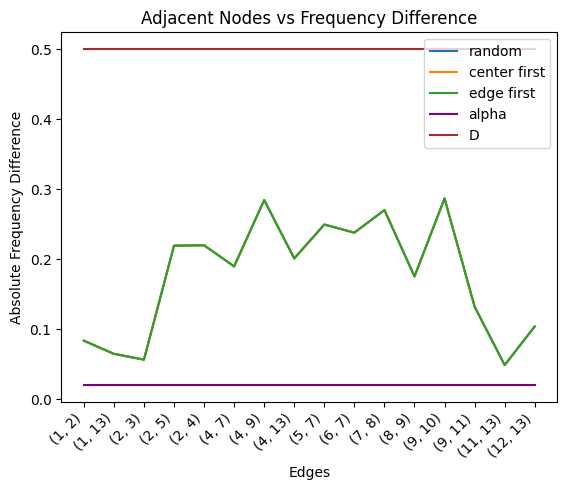

In [20]:
order_list = [None, [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12], [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]]
labels =["random", "center first", "edge first"]
points = run_n_visualize(qdata_stable, labels, order_list)


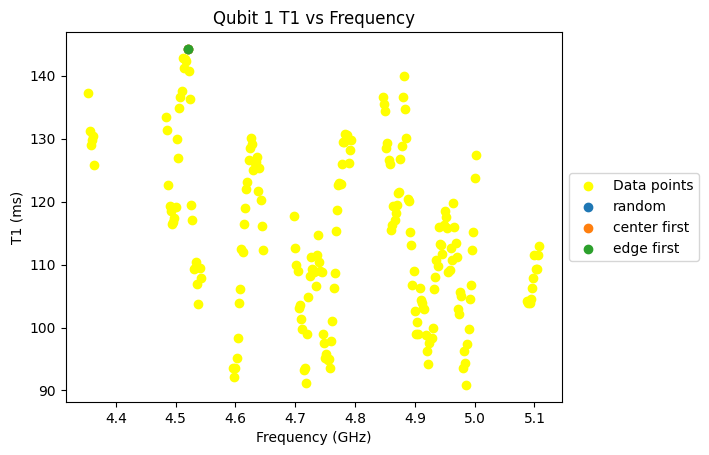

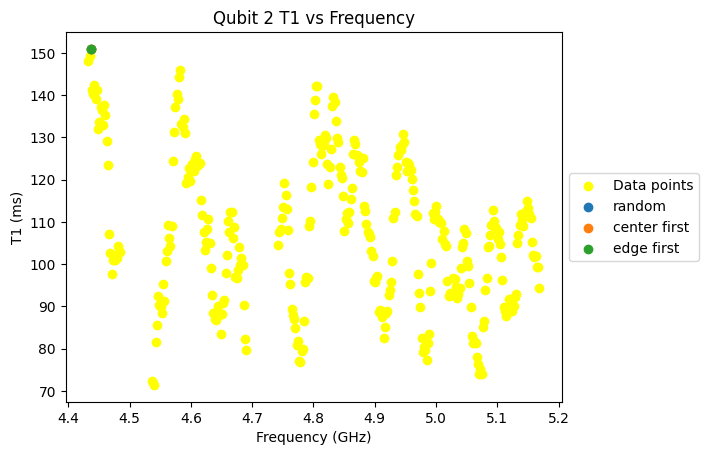

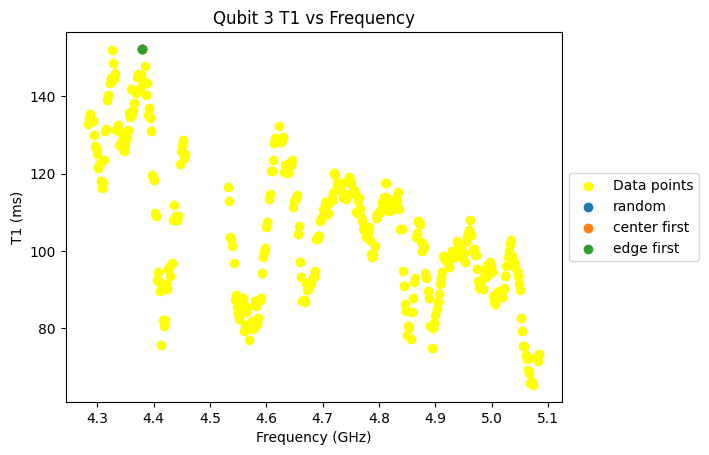

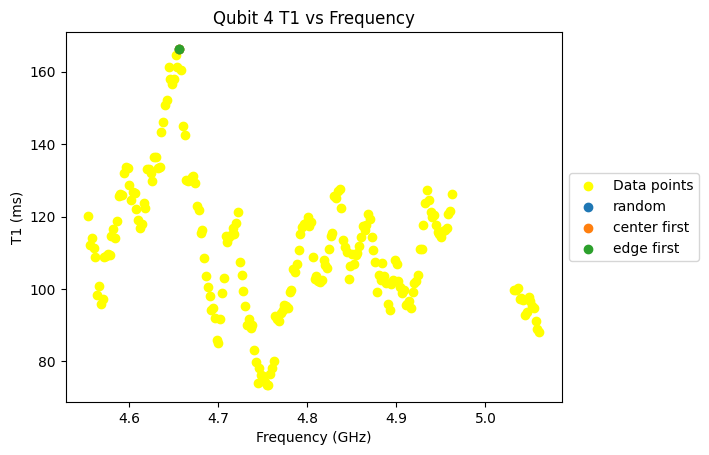

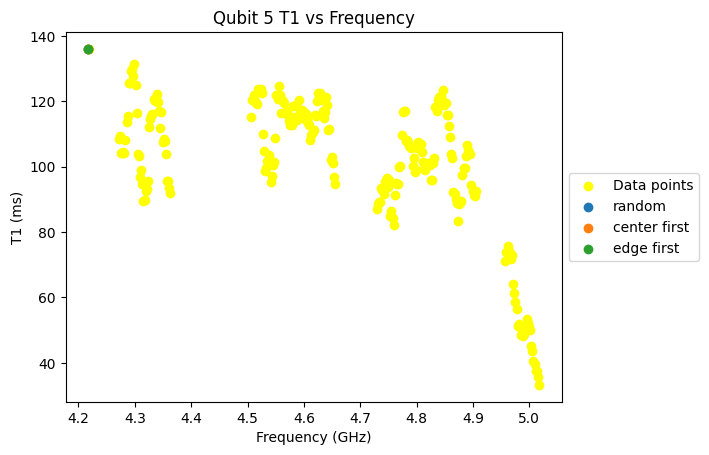

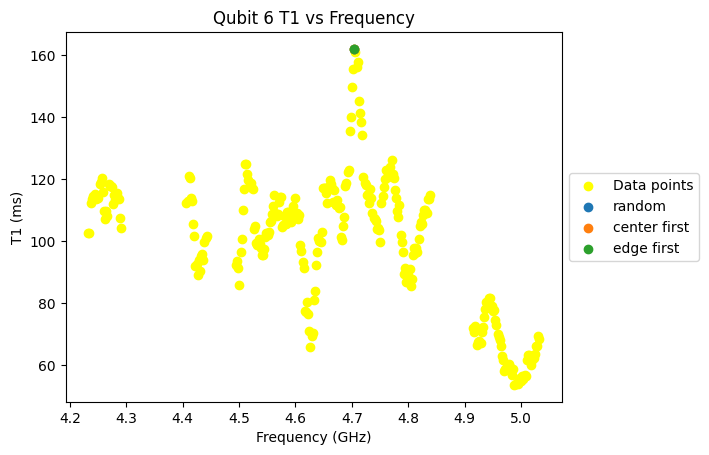

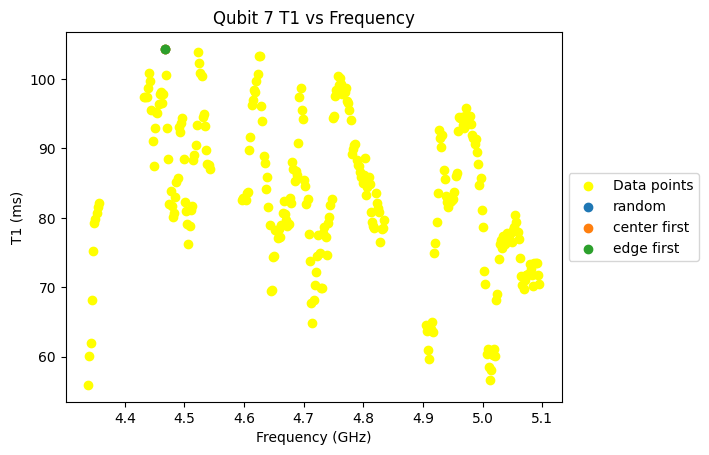

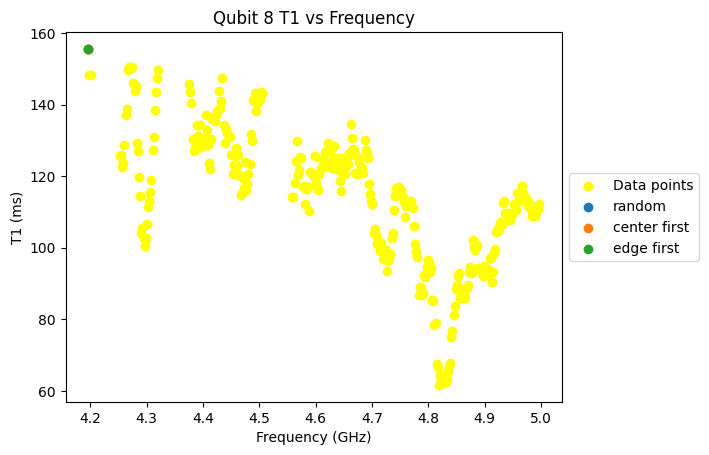

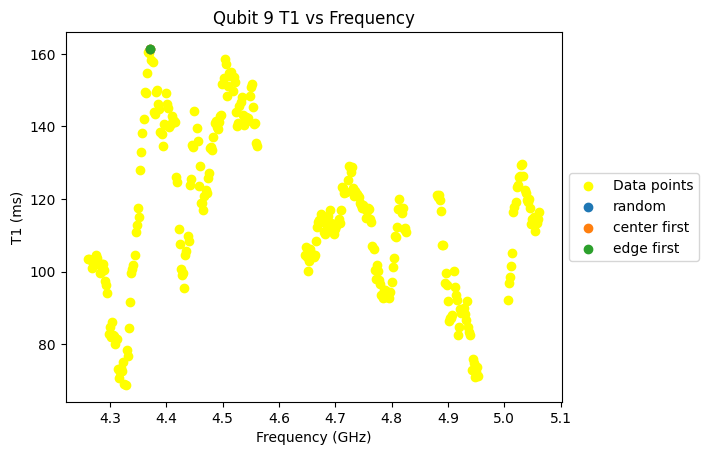

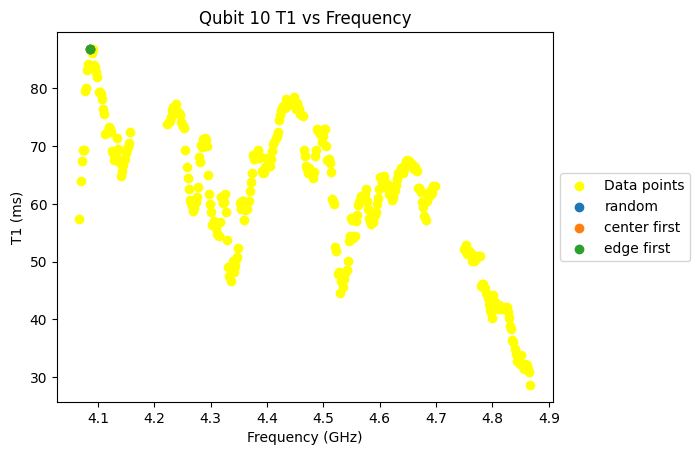

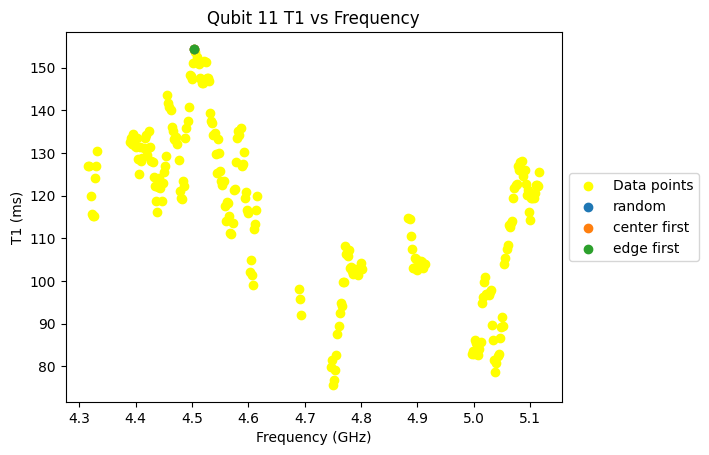

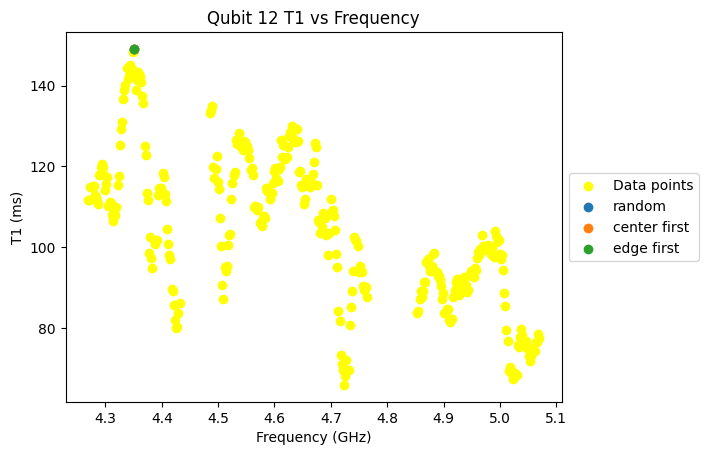

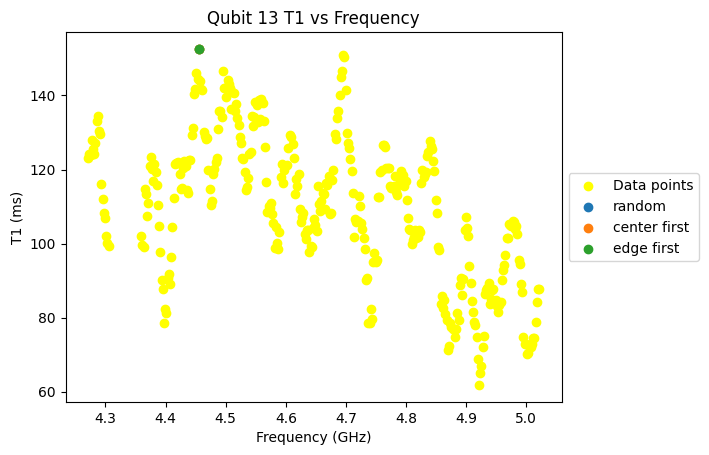

In [21]:
visualize_results(qdata_stable, points, labels)

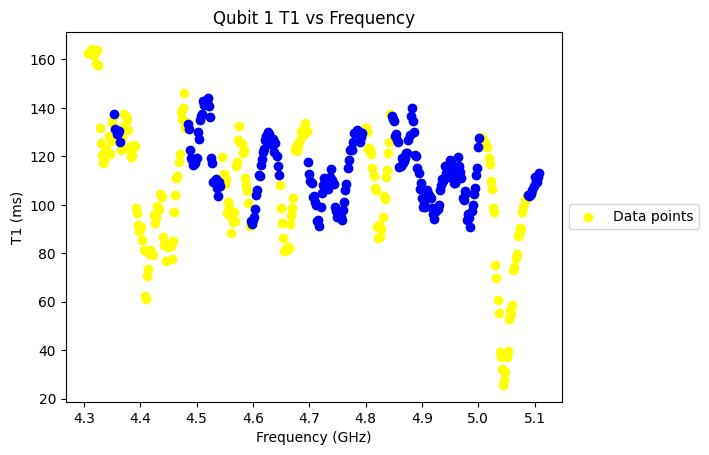

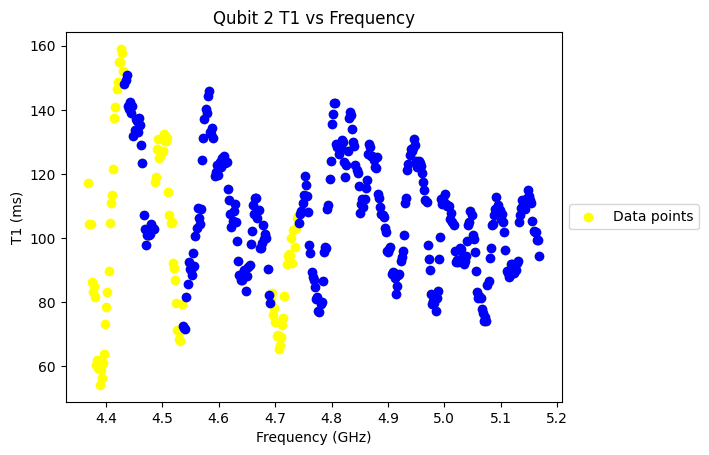

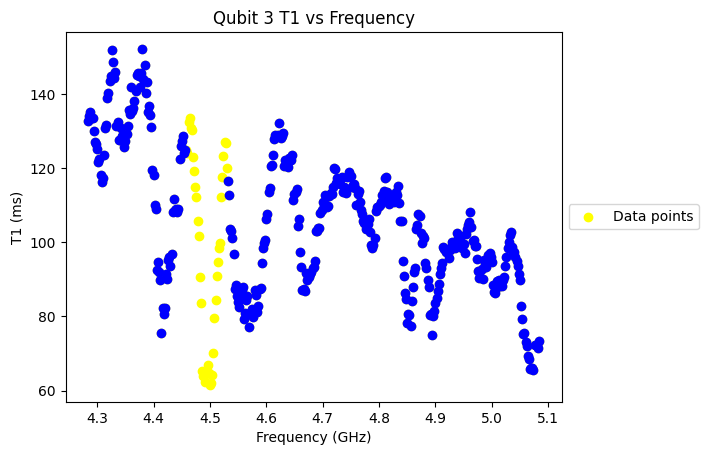

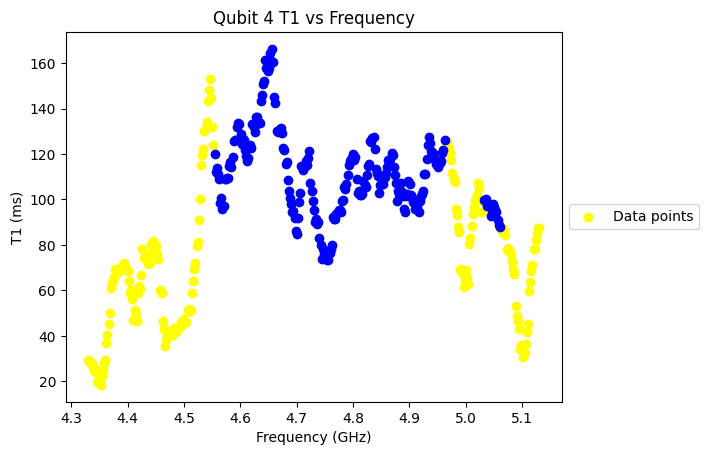

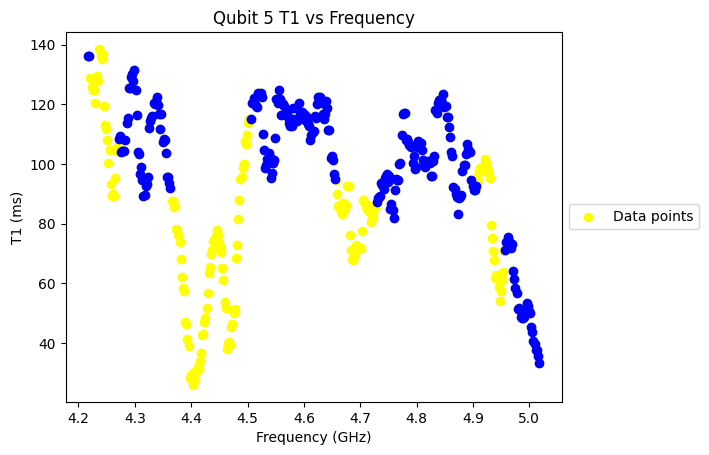

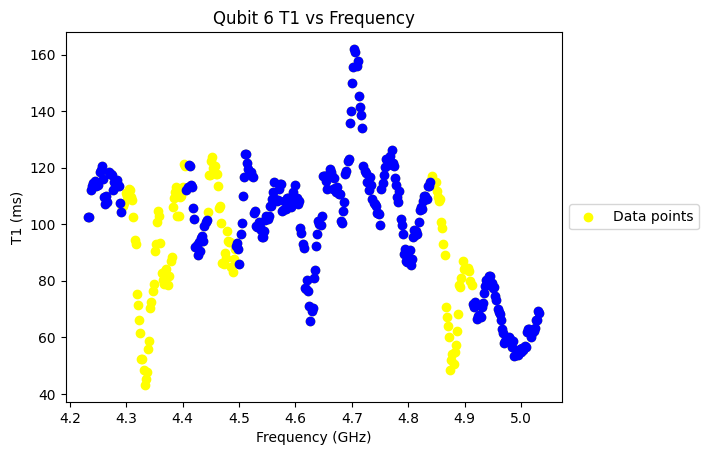

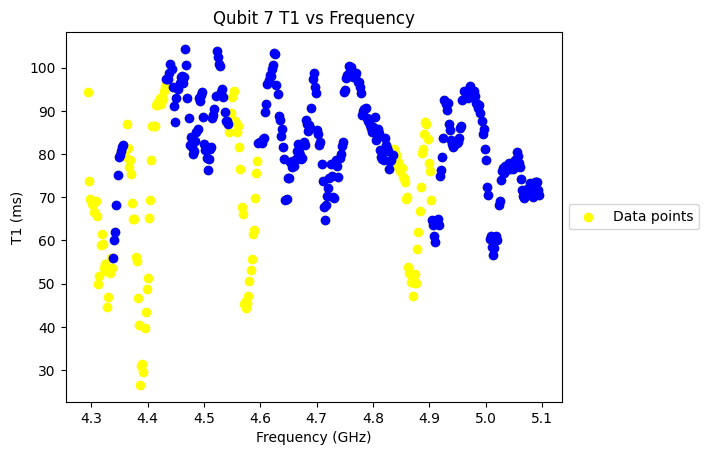

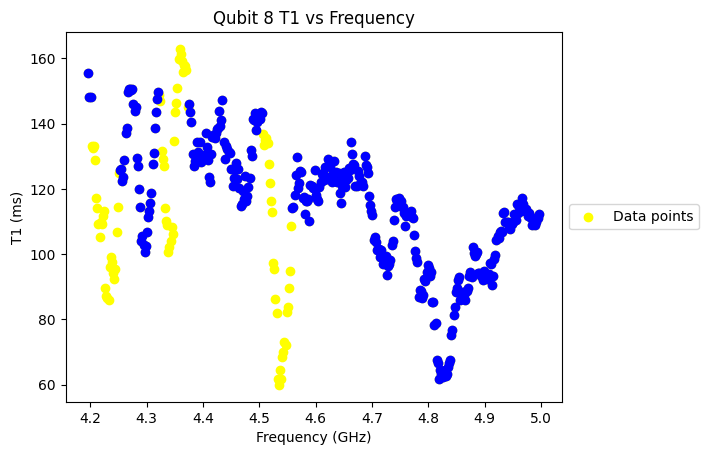

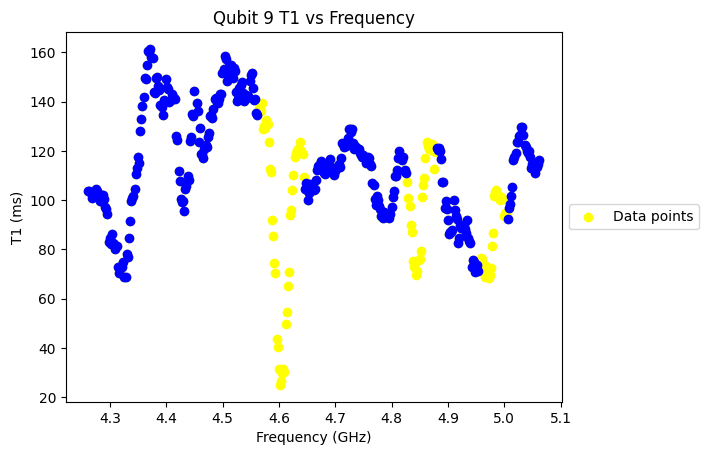

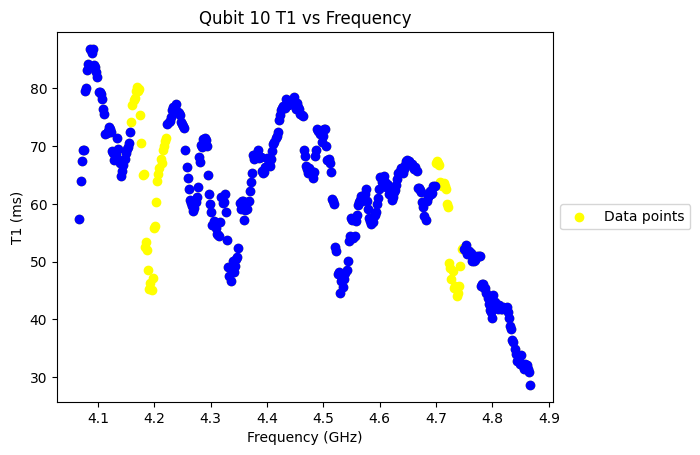

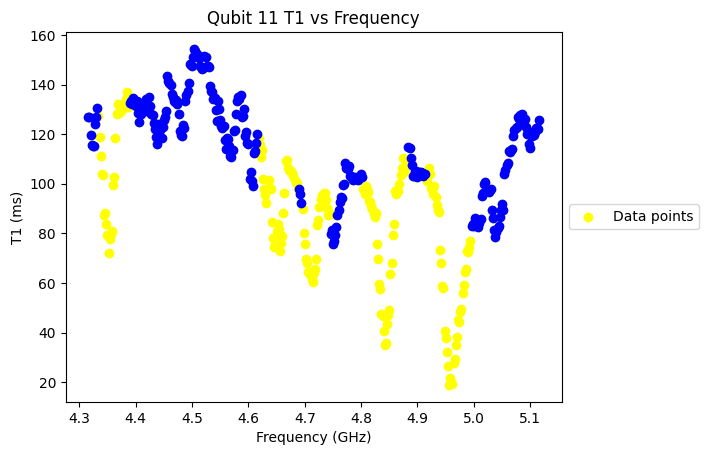

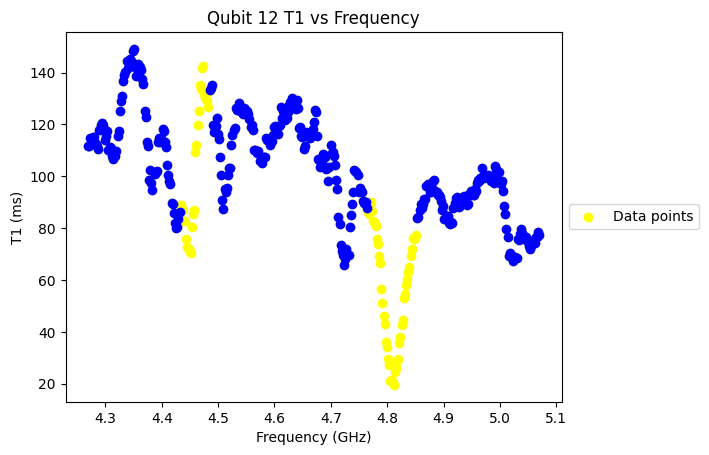

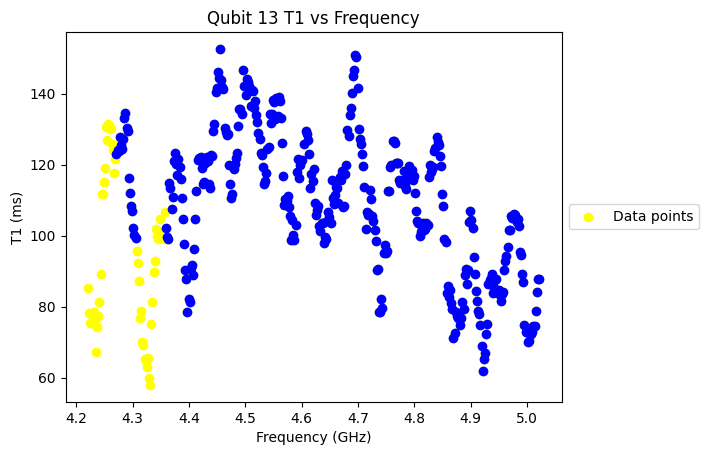

In [22]:
# Visualize legal_freq_dots

for i, (freq, t1) in qdata_smoothed.items():
    plt.scatter(freq, t1, color='yellow', label='Data points')
    plt.title(f'Qubit {i} T1 vs Frequency')

    for x, y in legal_freq_dots[i]:
        plt.scatter(x, y, color='blue')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('T1 (ms)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()